In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input_auto/中国柴油实际消费量Non-Trend-F0.2.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['中国柴油实际消费量Non-Trend/F0.2'].last_valid_index()

sheet.columns  

Index(['中国柴油实际消费量Non-Trend/F0.2', '中国10年期国债收益率Non-Trend/F0.1',
       'DR007利率/15DMA-1年期MLF利率', '中国期限利差-美国期限利差',
       '30大中城市商品房成交面积/7DMA(预测/上一年季节性)', '周度螺纹表需Non-Trend/F0.2(预测/上一年季节性)',
       '水泥表观消费Non-Trend/F0.2(预测/上一年季节性)',
       '每日建材成交/5DMANon-Trend/F0.1(预测/上一年季节性)',
       '五大钢材周度表需Non-Trend/F0.1(预测/上一年季节性)', '铁矿港口成交量/5DMA(预测/上一年季节性)',
       'SMM中国电线电缆周度开工率(预测/上一年季节性)', '玻璃周度表需（考虑中游）(预测/移动平均同比)',
       '铝棒周度产量/Mysteel(预测/上一年季节性)'],
      dtype='object')

In [4]:

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]


################################# 处理缺失值 #################################
fill_methods = {
    '中国10年期国债收益率Non-Trend/F0.1':'interpolate',
    'DR007利率/15DMA-1年期MLF利率':'interpolate', 
    '中国期限利差-美国期限利差':'interpolate',
    '30大中城市商品房成交面积/7DMA(预测/上一年季节性)':'interpolate', 
    '周度螺纹表需Non-Trend/F0.2(预测/上一年季节性)':'interpolate',
    '水泥表观消费Non-Trend/F0.2(预测/上一年季节性)':'interpolate',
    '每日建材成交/5DMANon-Trend/F0.1(预测/上一年季节性)':'interpolate',
    '五大钢材周度表需Non-Trend/F0.1(预测/上一年季节性)':'interpolate', 
    '铁矿港口成交量/5DMA(预测/上一年季节性)':'interpolate',
    'SMM中国电线电缆周度开工率(预测/上一年季节性)':'interpolate', 
    '玻璃周度表需（考虑中游）(预测/移动平均同比)':'interpolate',
    '铝棒周度产量/Mysteel(预测/上一年季节性)':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '中国柴油实际消费量Non-Trend/F0.2'] = sheet.loc[:last_day, '中国柴油实际消费量Non-Trend/F0.2'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['中国10年期国债收益率Non-Trend/F0.1_提前20天'] = sheet['中国10年期国债收益率Non-Trend/F0.1'].shift(20)
sheet['DR007利率/15DMA-1年期MLF利率_提前80天'] = sheet['DR007利率/15DMA-1年期MLF利率'].shift(80)
sheet['中国期限利差-美国期限利差_提前90天'] = sheet['中国期限利差-美国期限利差'].shift(90)


################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['中国柴油实际消费量Non-Trend/F0.2'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [5]:
sheet_daily.tail()

,Date,中国柴油实际消费量Non-Trend/F0.2,中国10年期国债收益率Non-Trend/F0.1,DR007利率/15DMA-1年期MLF利率,中国期限利差-美国期限利差,30大中城市商品房成交面积/7DMA(预测/上一年季节性),周度螺纹表需Non-Trend/F0.2(预测/上一年季节性),水泥表观消费Non-Trend/F0.2(预测/上一年季节性),每日建材成交/5DMANon-Trend/F0.1(预测/上一年季节性),五大钢材周度表需Non-Trend/F0.1(预测/上一年季节性),铁矿港口成交量/5DMA(预测/上一年季节性),SMM中国电线电缆周度开工率(预测/上一年季节性),玻璃周度表需（考虑中游）(预测/移动平均同比),铝棒周度产量/Mysteel(预测/上一年季节性),中国10年期国债收益率Non-Trend/F0.1_提前20天,DR007利率/15DMA-1年期MLF利率_提前80天,中国期限利差-美国期限利差_提前90天
887,2025-06-16,NaN,0.0461,1.6691,-0.0841,23.7814,-35.3948,7.1033,5348.4881,-76.2547,105.628,75.4942,106.95592,38.0242,0.0461,-0.094400,-0.010967
888,2025-06-17,NaN,0.0461,1.6691,-0.0841,26.0699,-35.3948,7.1033,5348.4881,-76.2547,105.628,75.4942,105.60164,38.0242,0.0461,-0.113000,0.004767
889,2025-06-18,NaN,0.0461,1.6691,-0.0841,27.5491,-35.3948,7.1033,5348.4881,-76.2547,105.628,75.4942,104.24736,38.0242,0.0461,-0.145400,0.020500
890,2025-06-19,NaN,0.0461,1.6691,-0.0841,28.2733,-35.3948,7.1033,5348.4881,-76.2547,105.628,75.4942,102.89308,38.0242,0.0461,-0.169200,0.048000
891,2025-06-20,NaN,0.0461,1.6691,-0.0841,30.0771,-35.3948,7.1033,5348.4881,-76.2547,105.628,75.4942,101.53880,38.0242,0.0461,-0.171233,0.012400


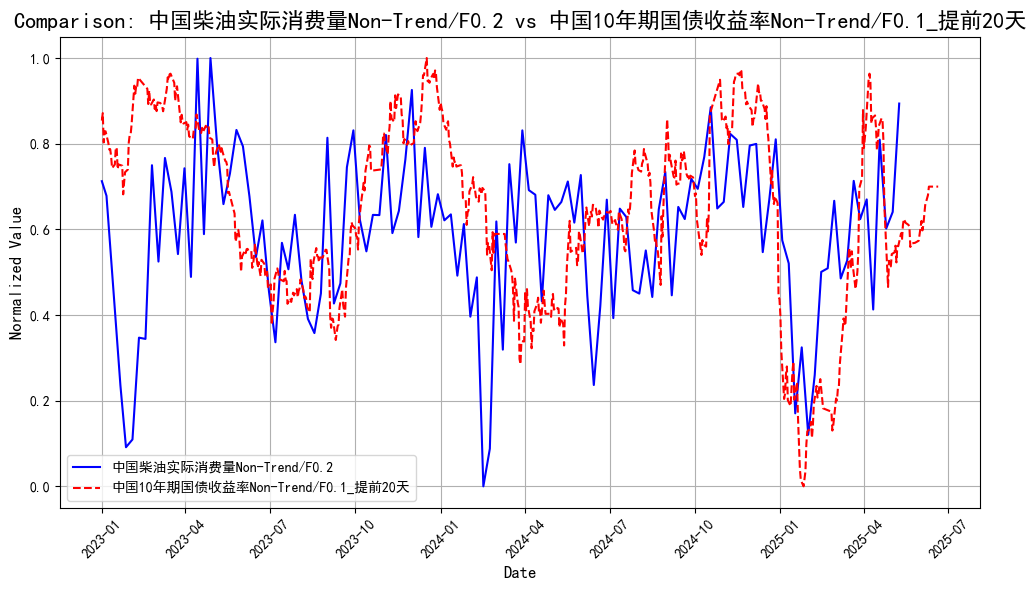

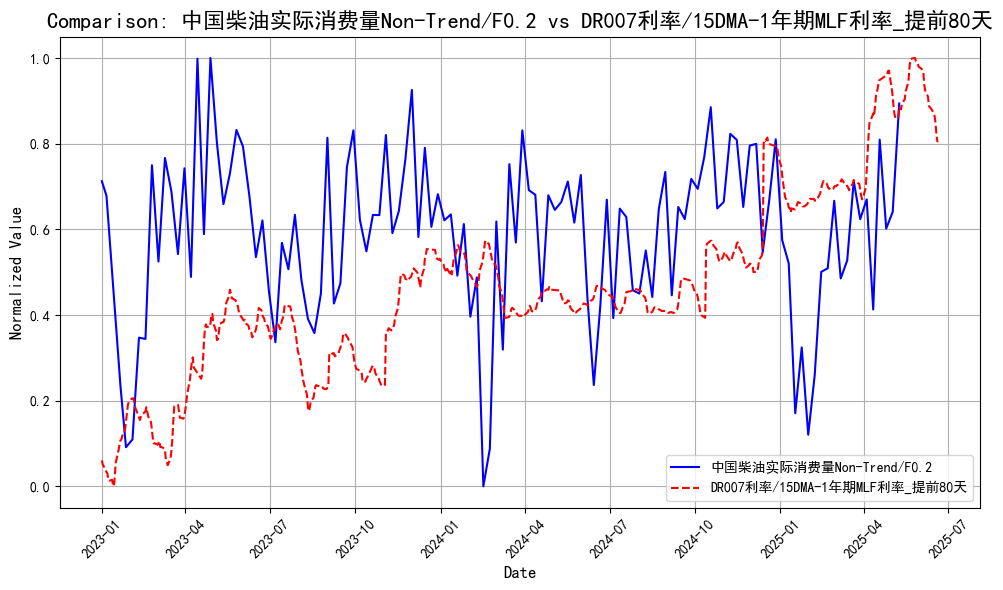

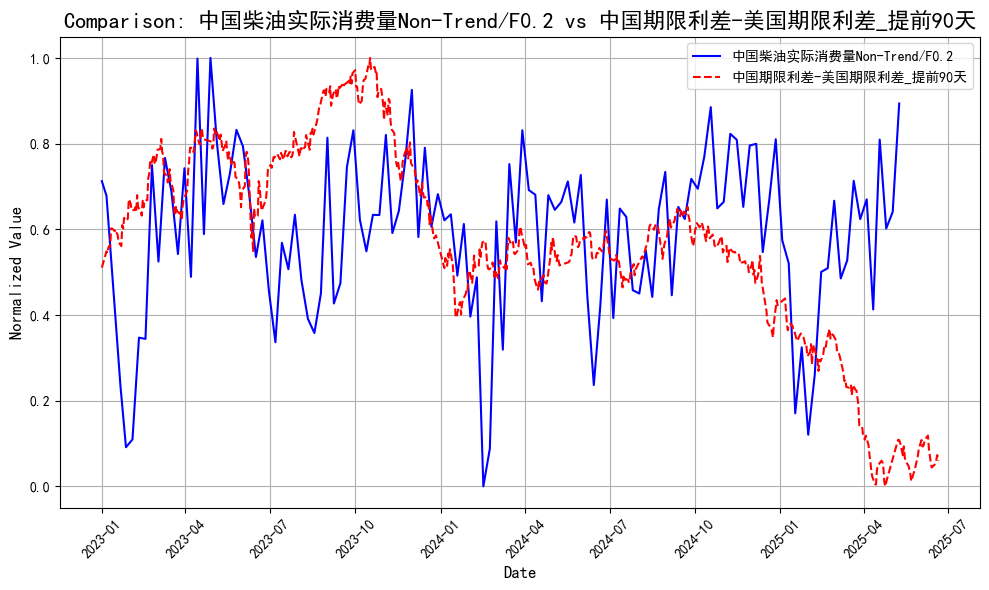

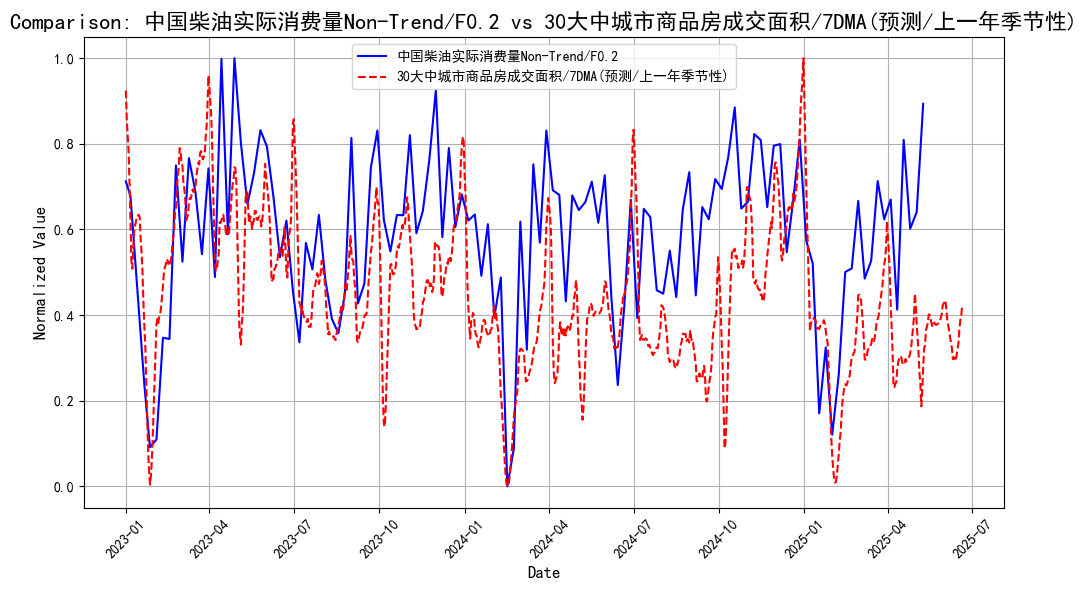

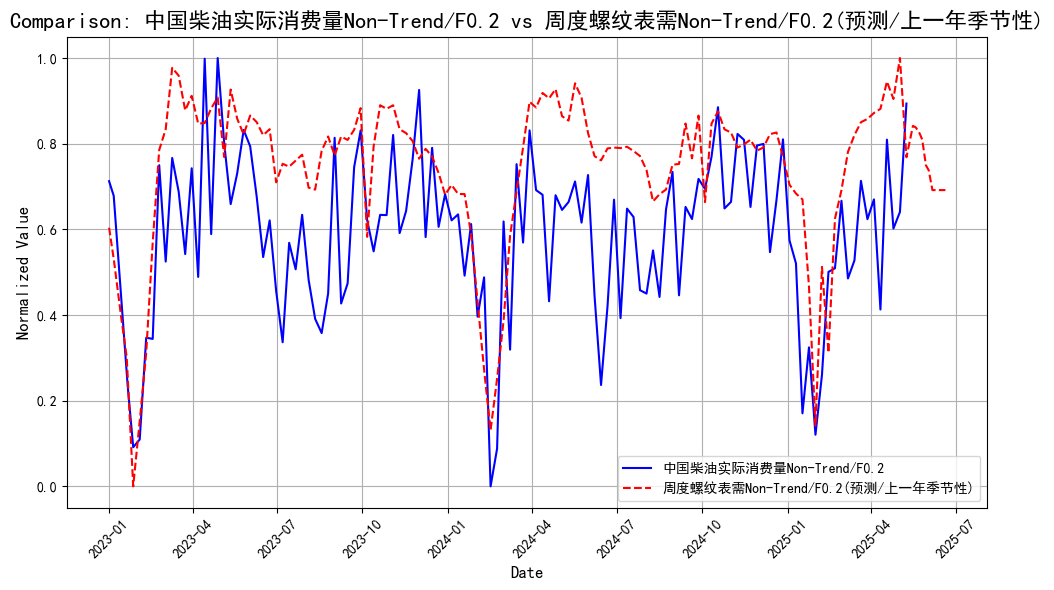

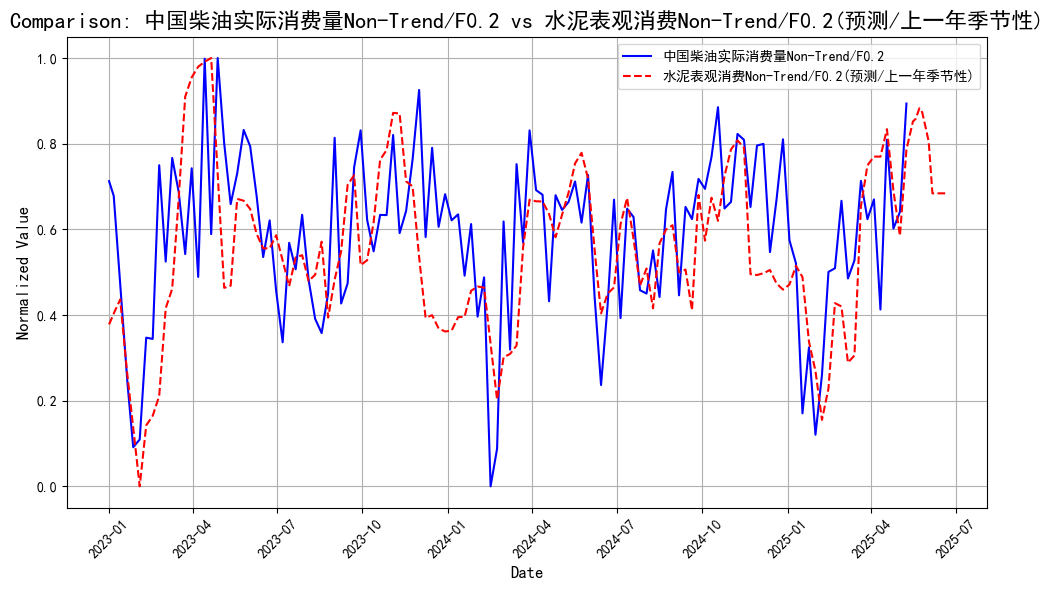

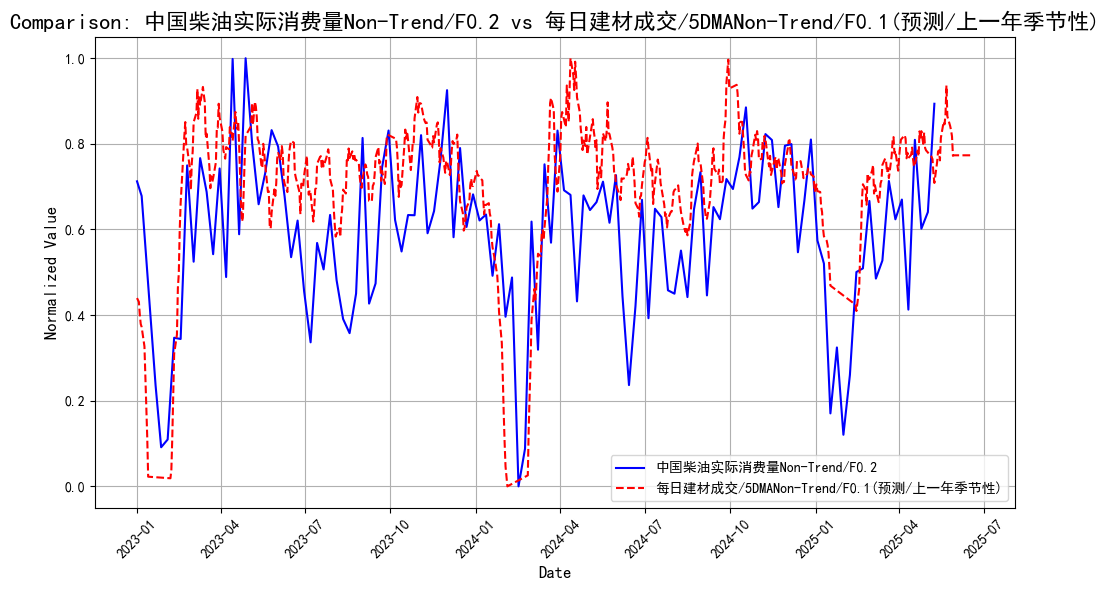

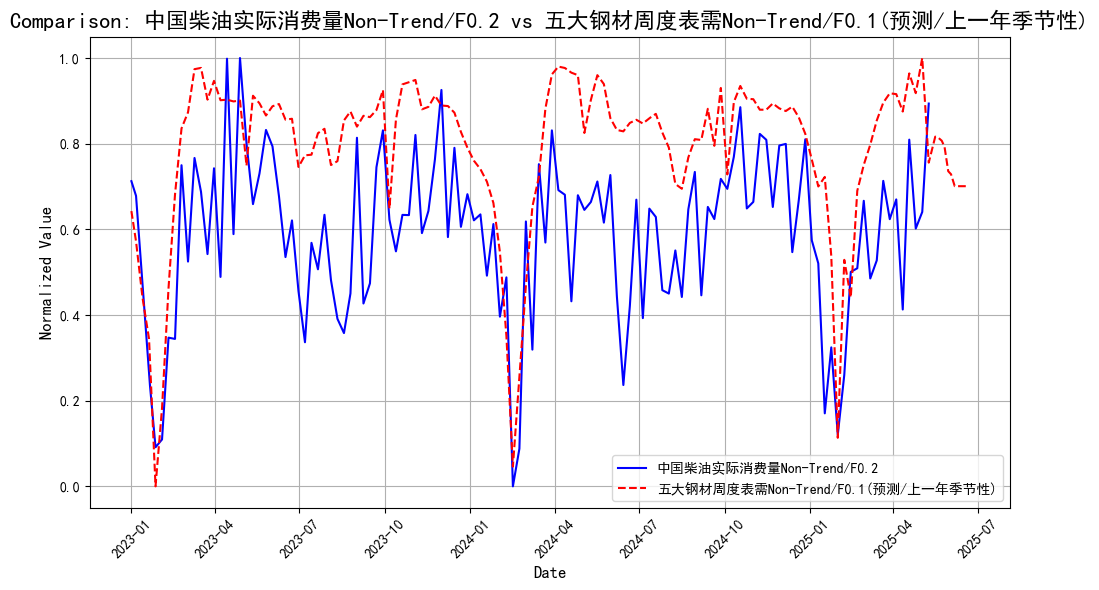

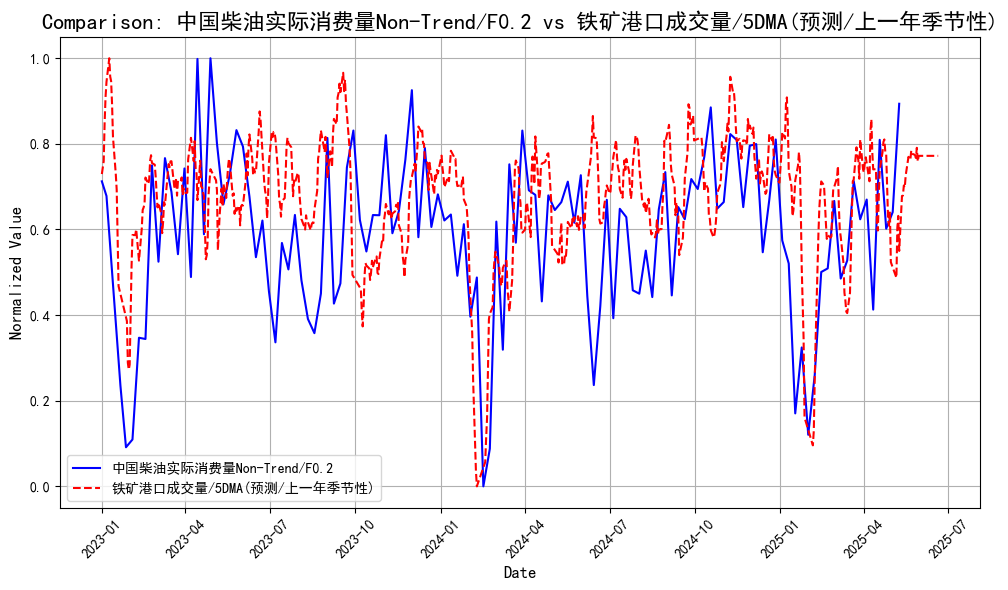

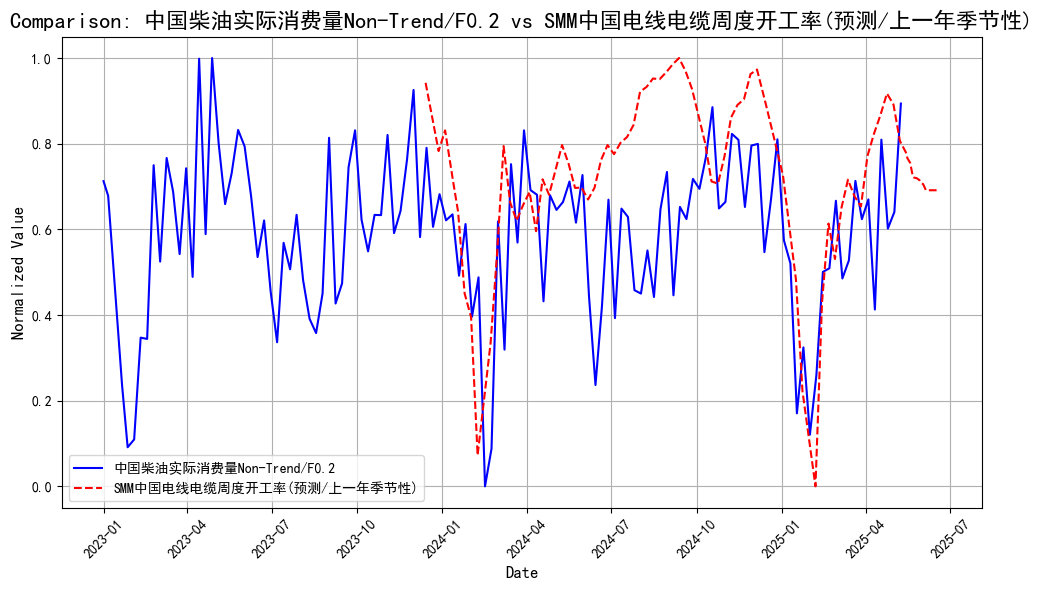

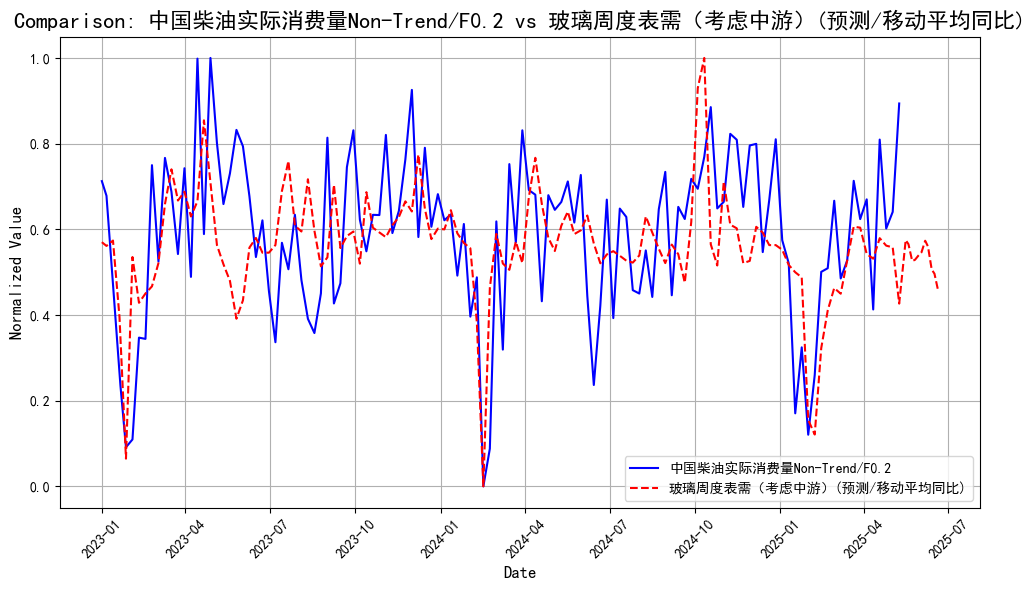

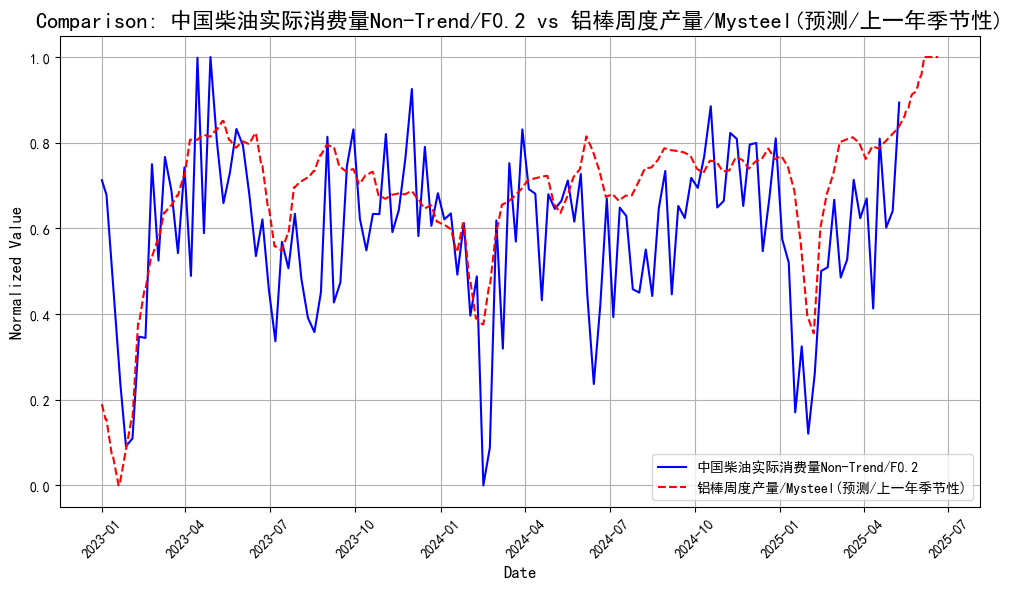

In [6]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国柴油实际消费量Non-Trend/F0.2', 
    compare_cols=[
        '中国10年期国债收益率Non-Trend/F0.1_提前20天',
        'DR007利率/15DMA-1年期MLF利率_提前80天',
        '中国期限利差-美国期限利差_提前90天',
        '30大中城市商品房成交面积/7DMA(预测/上一年季节性)',
        '周度螺纹表需Non-Trend/F0.2(预测/上一年季节性)',
        '水泥表观消费Non-Trend/F0.2(预测/上一年季节性)',
        '每日建材成交/5DMANon-Trend/F0.1(预测/上一年季节性)',
        '五大钢材周度表需Non-Trend/F0.1(预测/上一年季节性)',
        '铁矿港口成交量/5DMA(预测/上一年季节性)',
        'SMM中国电线电缆周度开工率(预测/上一年季节性)',
        '玻璃周度表需（考虑中游）(预测/移动平均同比)',
        '铝棒周度产量/Mysteel(预测/上一年季节性)'
       ]
)

In [7]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 50
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '中国10年期国债收益率Non-Trend/F0.1_提前20天',
        'DR007利率/15DMA-1年期MLF利率_提前80天',
        '中国期限利差-美国期限利差_提前90天',
        '30大中城市商品房成交面积/7DMA(预测/上一年季节性)',
        '周度螺纹表需Non-Trend/F0.2(预测/上一年季节性)',
        '水泥表观消费Non-Trend/F0.2(预测/上一年季节性)',
        '每日建材成交/5DMANon-Trend/F0.1(预测/上一年季节性)',
        '五大钢材周度表需Non-Trend/F0.1(预测/上一年季节性)',
        '铁矿港口成交量/5DMA(预测/上一年季节性)',
        'SMM中国电线电缆周度开工率(预测/上一年季节性)',
        '玻璃周度表需（考虑中游）(预测/移动平均同比)',
        '铝棒周度产量/Mysteel(预测/上一年季节性)'
]

predict_column = '中国柴油实际消费量Non-Trend/F0.2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth': 12,  # 控制树的深度防止过拟合
    'min_child_weight': 1,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.9,  # 特征随机采样
    'gamma': 0,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
    'max_delta_step': 5,
    'tree_method': 'auto'
}

num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:23.04091	train-rmse:32.52081


[100]	eval-rmse:21.74176	train-rmse:29.15980


[200]	eval-rmse:20.65886	train-rmse:26.01574


[300]	eval-rmse:19.97966	train-rmse:23.12066

[400]	eval-rmse:19.55306	train-rmse:20.41883


[500]	eval-rmse:19.24024	train-rmse:17.90511


[600]	eval-rmse:18.88533	train-rmse:15.58690


[700]	eval-rmse:18.66076	train-rmse:13.51359


[800]	eval-rmse:18.63189	train-rmse:11.69395


[900]	eval-rmse:18.76659	train-rmse:10.11994


[1000]	eval-rmse:18.85090	train-rmse:8.74811

[1100]	eval-rmse:18.84623	train-rmse:7.52788


[1200]	eval-rmse:18.84396	train-rmse:6.42642


[1300]	eval-rmse:18.82776	train-rmse:5.43436


[1400]	eval-rmse:18.79228	train-rmse:4.54620


[1500]	eval-rmse:18.76197	train-rmse:3.75123


[1600]	eval-rmse:18.74547	train-rmse:3.04204


[1700]	eval-rmse:18.72456	train-rmse:2.41016


[1800]	eval-rmse:18.72279	train-rmse:1.85577


[1900]	eval-rmse:18.71351	train-rmse:1.37808


[2000]	eval-rmse:18.71021	train-rmse:0.99786


[2100]	eval-rmse:18.70738	train-rmse:0.68676


[2200]	eval-rmse:18.70918	train-rmse:0.46392


[2300]	eval-rmse:18.70994	train-rmse:0.33540


[2400]	eval-rmse:18.70847	train-rmse:0.26151


[2500]	eval-rmse:18.70548	train-rmse:0.21452


[2600]	eval-rmse:18.70578	train-rmse:0.18382


[2700]	eval-rmse:18.70597	train-rmse:0.16146

[2800]	eval-rmse:18.70490	train-rmse:0.14404


[2900]	eval-rmse:18.70571	train-rmse:0.12853


[3000]	eval-rmse:18.70578	train-rmse:0.11523


[3100]	eval-rmse:18.70570	train-rmse:0.10264

[3200]	eval-rmse:18.70580	train-rmse:0.09223


[3300]	eval-rmse:18.70525	train-rmse:0.08290


[3400]	eval-rmse:18.70523	train-rmse:0.07490


[3500]	eval-rmse:18.70569	train-rmse:0.06805


[3600]	eval-rmse:18.70601	train-rmse:0.06136

[3700]	eval-rmse:18.70569	train-rmse:0.05570


[3800]	eval-rmse:18.70577	train-rmse:0.05078


[3900]	eval-rmse:18.70552	train-rmse:0.04639


[4000]	eval-rmse:18.70534	train-rmse:0.04247


[4100]	eval-rmse:18.70523	train-rmse:0.03876


[4200]	eval-rmse:18.70509	train-rmse:0.03558


[4300]	eval-rmse:18.70504	train-rmse:0.03284


[4400]	eval-rmse:18.70489	train-rmse:0.03048


[4500]	eval-rmse:18.70479	train-rmse:0.02829


[4600]	eval-rmse:18.70476	train-rmse:0.02633


[4700]	eval-rmse:18.70478	train-rmse:0.02450

[4800]	eval-rmse:18.70468	train-rmse:0.02301

[4900]	eval-rmse:18.70474	train-rmse:0.02169


[4999]	eval-rmse:18.70478	train-rmse:0.02051


训练集 MSE (DMatrix): 0.0006, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 349.8688, 测试集 R² (DMatrix): 0.0643


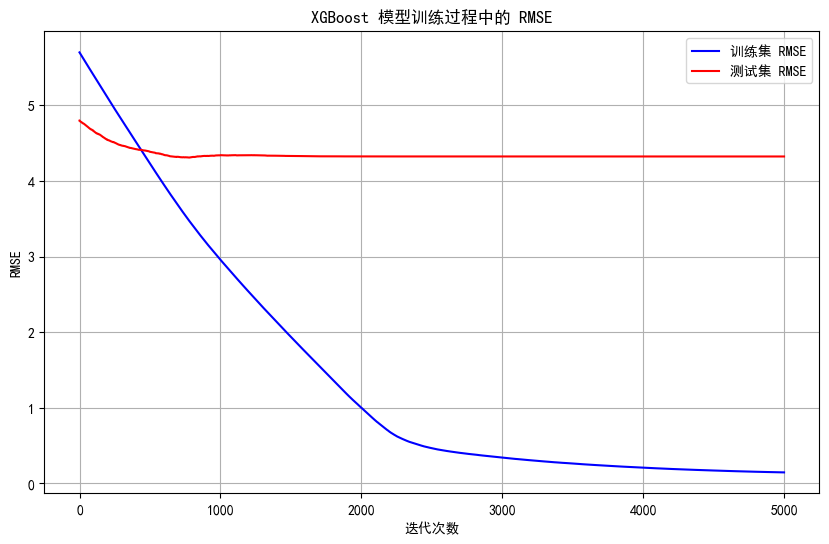

In [8]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=200
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:31.98087


[200]	train-rmse:25.59321


[400]	train-rmse:20.07215


[600]	train-rmse:15.28630


[800]	train-rmse:11.48321


[1000]	train-rmse:8.61175


[1200]	train-rmse:6.35138


[1400]	train-rmse:4.51807


[1600]	train-rmse:3.04720


[1800]	train-rmse:1.87998


[2000]	train-rmse:1.02232


[2200]	train-rmse:0.47376


[2400]	train-rmse:0.25457


[2600]	train-rmse:0.17900


[2800]	train-rmse:0.13996


[3000]	train-rmse:0.11324


[3200]	train-rmse:0.09254


[3400]	train-rmse:0.07633


[3600]	train-rmse:0.06366


[3800]	train-rmse:0.05328


[4000]	train-rmse:0.04508


[4200]	train-rmse:0.03823


[4400]	train-rmse:0.03300


[4600]	train-rmse:0.02871


[4800]	train-rmse:0.02518


[4999]	train-rmse:0.02245


全部数据 MSE: 0.0008, 全部数据 R²: 1.0


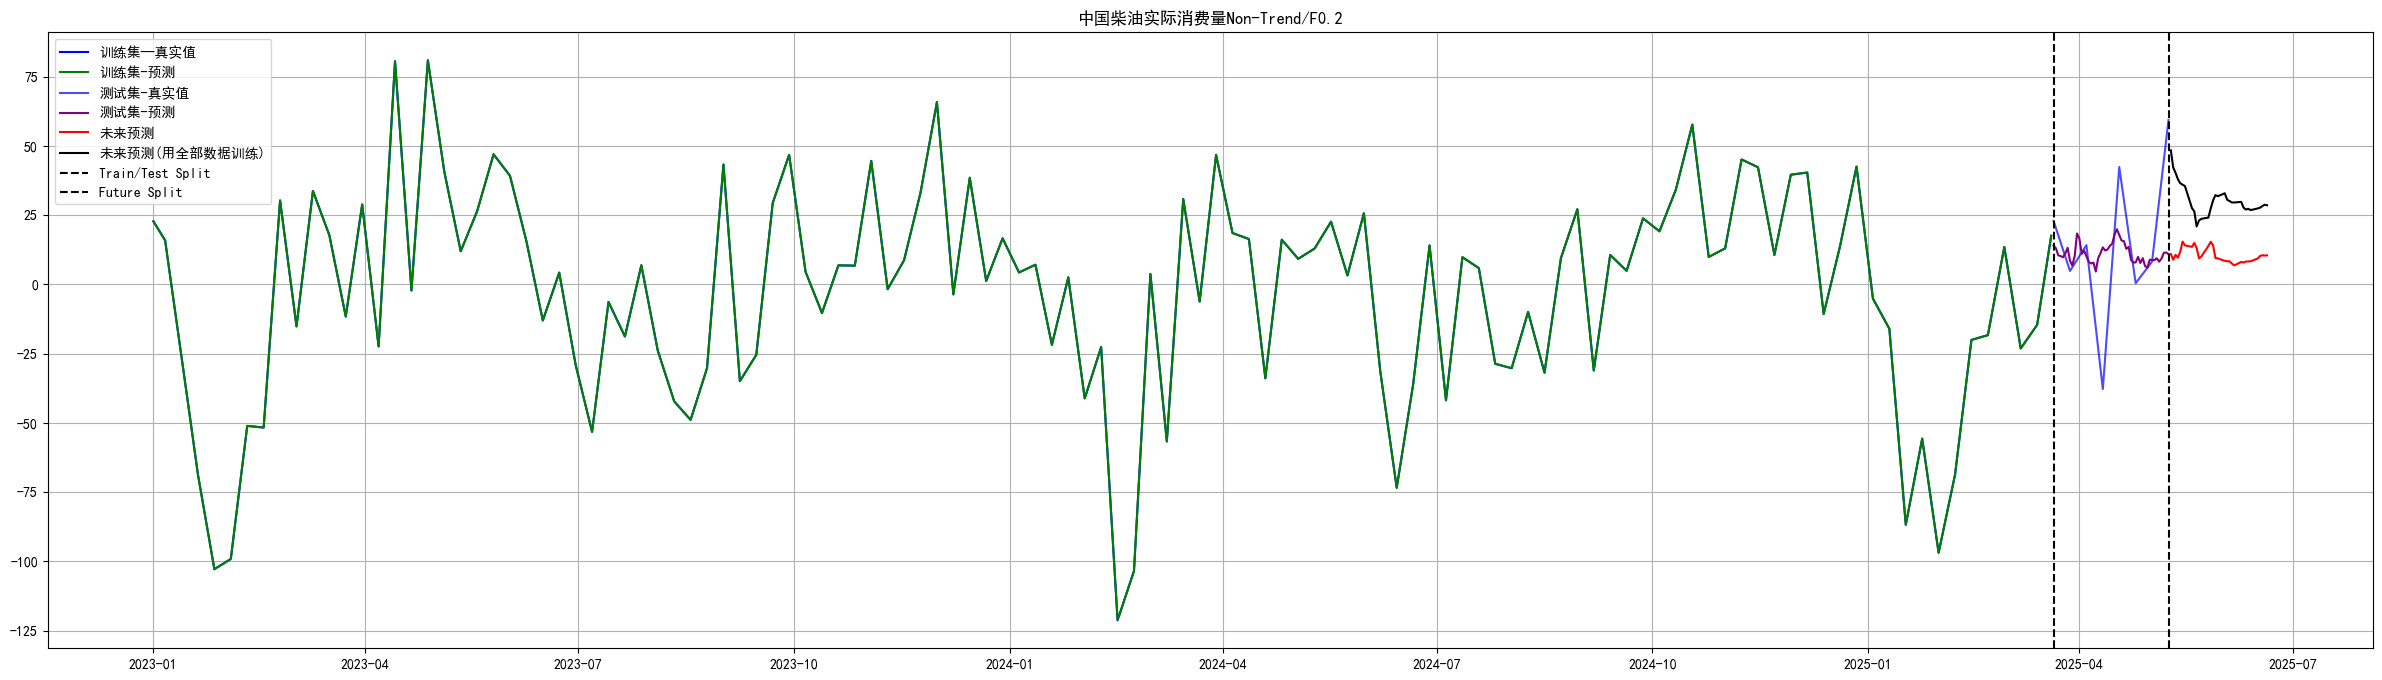

In [10]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('中国柴油实际消费量Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()


---

In [11]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/中国柴油实际消费量Non-Trend-F0.2_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/中国柴油实际消费量Non-Trend-F0.2_月度数据.xlsx', index=False,float_format= '%.4f')

In [12]:
merged_df_daily

,Date,真实值,预测值
891,2025/06/20,NaN,28.535099
890,2025/06/19,NaN,28.715647
889,2025/06/18,NaN,28.246323
888,2025/06/17,NaN,27.631775
887,2025/06/16,NaN,27.378651
...,...,...,...
4,2023/01/05,17.2113,NaN
3,2023/01/04,18.5952,NaN
2,2023/01/03,19.9791,NaN
1,2023/01/02,21.3630,NaN


In [13]:
merged_df_monthly

,Date,真实值,预测值
29,2025/06/30,NaN,28.764906
28,2025/05/31,30.831506,24.256712
27,2025/04/30,4.760150,11.417855
26,2025/03/31,-0.725373,-0.975705
25,2025/02/28,-35.251414,-35.253094
24,2025/01/31,-48.663154,-48.661301
23,2024/12/31,21.126476,21.125977
22,2024/11/30,31.167868,31.168230
21,2024/10/31,28.673504,28.672445
20,2024/09/30,3.851020,3.850805


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国柴油实际消费量Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国柴油实际消费量Non-Trend/F0.2"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件
